<a href="https://colab.research.google.com/github/FlameDanita/Neural_Networks_and_CV/blob/master/module04_mnist_fc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [2]:
import torchvision.datasets
MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [3]:
X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = MNIST_test.test_data
y_test = MNIST_test.test_labels

/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.9/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


In [4]:
X_train.dtype, y_train.dtype

(torch.uint8, torch.int64)

In [5]:
X_train = X_train.float()
X_test = X_test.float()

In [6]:
X_train.shape, X_test.shape

(torch.Size([60000, 28, 28]), torch.Size([10000, 28, 28]))

In [7]:
y_train.shape, y_test.shape

(torch.Size([60000]), torch.Size([10000]))

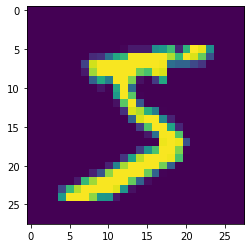

tensor(5)


In [8]:
import matplotlib.pyplot as plt

plt.imshow(X_train[0, :, :])
plt.show()
print(y_train[0])

In [9]:
X_train = X_train.reshape([-1, 28 * 28])
X_test = X_test.reshape([-1, 28 * 28])

In [10]:
class MNISTNet(torch.nn.Module):
    def __init__(self, n_hidden_neurons):
        super(MNISTNet, self).__init__()
        self.fc1 = torch.nn.Linear(28 * 28, n_hidden_neurons)
        self.ac1 = torch.nn.Sigmoid()
        self.fc2 = torch.nn.Linear(n_hidden_neurons, 10) 
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.ac1(x)
        x = self.fc2(x)
        return x
    
mnist_net = MNISTNet(100)

In [11]:
torch.cuda.is_available()

True

In [12]:
!nvidia-smi

Sun Mar 12 23:04:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P0    30W /  70W |      3MiB / 15360MiB |      5%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [13]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
mnist_net = mnist_net.to(device)
list(mnist_net.parameters())

[Parameter containing:
 tensor([[-0.0003,  0.0192, -0.0294,  ...,  0.0219,  0.0037,  0.0021],
         [-0.0198, -0.0150, -0.0104,  ..., -0.0203, -0.0060, -0.0299],
         [-0.0201,  0.0149, -0.0333,  ..., -0.0203,  0.0012,  0.0080],
         ...,
         [ 0.0221,  0.0258, -0.0088,  ..., -0.0141,  0.0051, -0.0318],
         [-0.0217, -0.0136,  0.0185,  ..., -0.0012, -0.0012, -0.0017],
         [ 0.0142,  0.0089, -0.0053,  ...,  0.0311, -0.0181,  0.0020]],
        device='cuda:0', requires_grad=True), Parameter containing:
 tensor([-3.5402e-02,  1.8178e-02, -2.1709e-02, -1.1839e-02,  4.8722e-03,
         -1.0492e-02, -1.9008e-02,  2.6994e-02, -3.4899e-02,  1.0381e-02,
         -3.5228e-02, -5.6381e-03, -2.0134e-02, -3.0264e-02, -1.3289e-02,
          2.5346e-02, -1.0797e-02,  2.1568e-03,  4.3630e-03, -2.1916e-02,
          2.2670e-02, -1.5766e-02,  3.4906e-02, -2.3063e-02, -6.8216e-03,
          2.7051e-02, -1.3991e-02,  9.7218e-03, -9.9075e-04,  1.6625e-03,
          2.3455e-02, -2

In [14]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mnist_net.parameters(), lr=1.0e-3)

In [15]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = mnist_net.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()

    test_preds = mnist_net.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().cpu()
    test_accuracy_history.append(accuracy)
    print(accuracy)

tensor(0.9073)
tensor(0.9177)
tensor(0.9235)
tensor(0.9172)
tensor(0.9218)
tensor(0.9247)
tensor(0.9289)
tensor(0.9262)
tensor(0.9311)
tensor(0.9314)
tensor(0.9388)
tensor(0.9284)
tensor(0.9312)
tensor(0.9383)
tensor(0.9374)
tensor(0.9346)
tensor(0.9401)
tensor(0.9434)
tensor(0.9426)
tensor(0.9390)
tensor(0.9438)
tensor(0.9434)
tensor(0.9388)
tensor(0.9387)
tensor(0.9411)
tensor(0.9394)
tensor(0.9432)
tensor(0.9444)
tensor(0.9426)
tensor(0.9484)
tensor(0.9469)
tensor(0.9465)
tensor(0.9448)
tensor(0.9440)
tensor(0.9486)
tensor(0.9483)
tensor(0.9492)
tensor(0.9490)
tensor(0.9456)
tensor(0.9485)
tensor(0.9446)
tensor(0.9490)
tensor(0.9519)
tensor(0.9460)
tensor(0.9495)
tensor(0.9533)
tensor(0.9519)
tensor(0.9503)
tensor(0.9528)
tensor(0.9543)


KeyboardInterrupt: ignored

RuntimeError: ignored

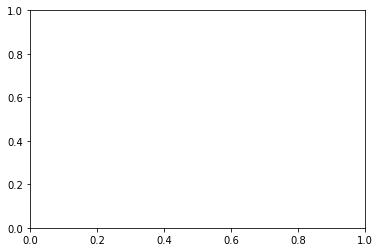

In [18]:
# plt.plot(test_accuracy_history)
plt.plot(test_loss_history)

I) График loss для train и validation:



1. Построил графики до 200 эпох.
    - test loss - как было в исходном примере
    - train loss (last batch in an epoch) - для каждой эпохи берется значение loss на последнем минибатче - поэтому график получился очень негладкий
    - train loss (evarage during each epoch) - среднее значения loss функции по всем минибатчам для каждой эпохи
    
2. Как видно из графика - train loss и test loss выходят на плато примерно после 150 эпохи. Test loss не начинает расти, можно сделать вывод, что переобучения нет.

II) Ведет ли увеличение количества эпох (40 эпох -> 200 эпох) к улучшению метрик на валидации?



На графике видно, что увеличение количества эпох с 40 до 200 приводит к улучшению метрики на валидации с 0.95 до 0.964

III) Замерьте время вычисления 100 эпох на CPU и на GPU. Какое ускорение вы наблюдаете?

На первом этапе я замерил скорость обучения на CPU и GPU, использую batch_size 100, получилось, что обучение на GPU проходит в 4,5 раза быстрее. Этого показалось мало и решил поэксперементировать с обучением при разных batch_size, чтобы получше использовать возможности GPU, ниже на графике показан результат (на графике по оси x - показаны n, где 2^n - размер batch_size):



Итого преимущество GPU при большом batch_size - в 8 раз, предполагаю, что при росте размера задачи - разрыв будет увеличиваться.

IV) Замедляет ли torch.backends.cudnn.deterministic = True обучение на практике? Если да, то насколько?

Попробовал замерить скорость с GPU и torch.backends.cudnn.deterministic =  False, аналогично предыдущему эксперименту. Не заметил значимых изменений в быстройдействии, даже немного быстрее с True:

torch.backends.cudnn.deterministic = False

batch_size = 64 Time elapsed: 75.21s
batch_size = 128 Time elapsed: 39.38s
batch_size = 256 Time elapsed: 21.76s
batch_size = 512 Time elapsed: 12.95s
batch_size = 1024 Time elapsed: 8.85s
batch_size = 2048 Time elapsed: 6.78s
batch_size = 4096 Time elapsed: 5.71s
batch_size = 8192 Time elapsed: 5.19s
torch.backends.cudnn.deterministic = True

batch_size = 64 Time elapsed: 74.92s
batch_size = 128 Time elapsed: 39.39s
batch_size = 256 Time elapsed: 21.55s
batch_size = 512 Time elapsed: 12.84s
batch_size = 1024 Time elapsed: 8.72s
batch_size = 2048 Time elapsed: 6.68s
batch_size = 4096 Time elapsed: 5.67s
batch_size = 8192 Time elapsed: 5.20s
V) Попробуйте разные методы градиентного спуска, которые были в лекции.

batch_size = 8192, обучение производил на GPU по 5 раз для каждого метода, на графике показана зависимость test accuracy от эпохи (графики усредненные по 5 экспериментам для каждого метода):



Видим,  что Adam и RMSprop показывают наилучшую accuracy после 200 эпох.

Accuracy после 200 эпох (средняя по 5 экспериментам):

SGD - 0.9193
Rprop - 0.9271
RMSprop - 0.9616
Adam - 0.9596